In [6]:
import sys
sys.path.append('../..')
import pandas as pd
import ta


In [7]:
from Tools.backtest_tools import get_n_columns, get_metrics, basic_single_asset_backtest, plot_wallet_vs_asset

In [3]:
class BBands:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
            BB_window = 100,
            BB_std = 2.25,
            BB_speard = 0,
            ma_window = 500) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.BB_window = BB_window
        self.BB_std = BB_std
        self.min_BB_spread = BB_speard
        self.ma_window = ma_window

    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        BB_band = ta.volatility.BollingerBands(close=df["close"], window=self.BB_window, window_dev=self.BB_std)
        df["lower_band"] = BB_band.bollinger_lband()
        df["higher_band"] = BB_band.bollinger_hband()
        df["ma_band"] = BB_band.bollinger_mavg()
        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=self.ma_window)

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_BB_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['ma_band']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_BB_spread)
                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['ma_band']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
    
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       

In [9]:
df = pd.read_csv('./crvusdt.csv')
df['datetime'] = pd.to_datetime(df['datetime'], unit="ms")
df.set_index('datetime', inplace=True)

In [10]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [11]:
df

,open,high,low,close,volume
datetime,,,,,
2024-08-25 08:13:00,0.3330,0.3334,0.3330,0.3332,130.5839
2024-08-25 08:14:00,0.3332,0.3333,0.3328,0.3333,183.8103
2024-08-25 08:15:00,0.3333,0.3336,0.3333,0.3335,90.4814
2024-08-25 08:16:00,0.3335,0.3340,0.3335,0.3338,345.0128
2024-08-25 08:17:00,0.3338,0.3340,0.3337,0.3340,76.3343
...,...,...,...,...,...
2024-08-26 00:49:00,0.3337,0.3339,0.3334,0.3334,62.2360
2024-08-26 00:50:00,0.3334,0.3336,0.3333,0.3336,74.9675
2024-08-26 00:51:00,0.3336,0.3336,0.3316,0.3318,157.5148


In [12]:


strat = BBands(
    df = df,
    type=["long","short"],
    BB_window = 100,
    BB_std = 2.25,
    BB_speard = 0,
    ma_window = 20,
)

strat.populate_indicators()
strat.populate_buy_sell()


,open,high,low,close,volume,lower_band,higher_band,ma_band,long_ma,n1_ma_band,n1_lower_band,n1_higher_band,n1_close,open_long_market,close_long_market,open_short_market,close_short_market
datetime,,,,,,,,,,,,,,,,,
2024-08-25 08:13:00,0.3330,0.3334,0.3330,0.3332,130.5839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2024-08-25 08:14:00,0.3332,0.3333,0.3328,0.3333,183.8103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3332,False,False,False,False
2024-08-25 08:15:00,0.3333,0.3336,0.3333,0.3335,90.4814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3333,False,False,False,False
2024-08-25 08:16:00,0.3335,0.3340,0.3335,0.3338,345.0128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3335,False,False,False,False
2024-08-25 08:17:00,0.3338,0.3340,0.3337,0.3340,76.3343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3338,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26 00:49:00,0.3337,0.3339,0.3334,0.3334,62.2360,0.331981,0.339411,0.335696,0.334410,0.335745,0.332021,0.339469,0.3337,False,True,False,False
2024-08-26 00:50:00,0.3334,0.3336,0.3333,0.3336,74.9675,0.331952,0.339346,0.335649,0.334330,0.335696,0.331981,0.339411,0.3334,False,True,False,False
2024-08-26 00:51:00,0.3336,0.3336,0.3316,0.3318,157.5148,0.331839,0.339327,0.335583,0.334180,0.335649,0.331952,0.339346,0.3336,False,True,True,False


Period: [2024-08-25 00:00:00] -> [2024-08-26 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 61.85 $
Performance vs US dollar: -93.81 %
Sharpe Ratio: -31.44
Worst Drawdown T|D: -93.8% | -93.81%
Buy and hold performance: 0.6 %
Performance vs buy and hold: -93.85 %
Total trades on the period: 478
Global Win rate: 10.04 %
Average Profit: -0.58 %
Total fees paid 224.89$

Best trades: +0.33 % the 2024-08-25 20:46:00 -> 2024-08-25 22:30:00
Worst trades: -1.22 % the 2024-08-26 00:51:00 -> 2024-08-25 08:23:00


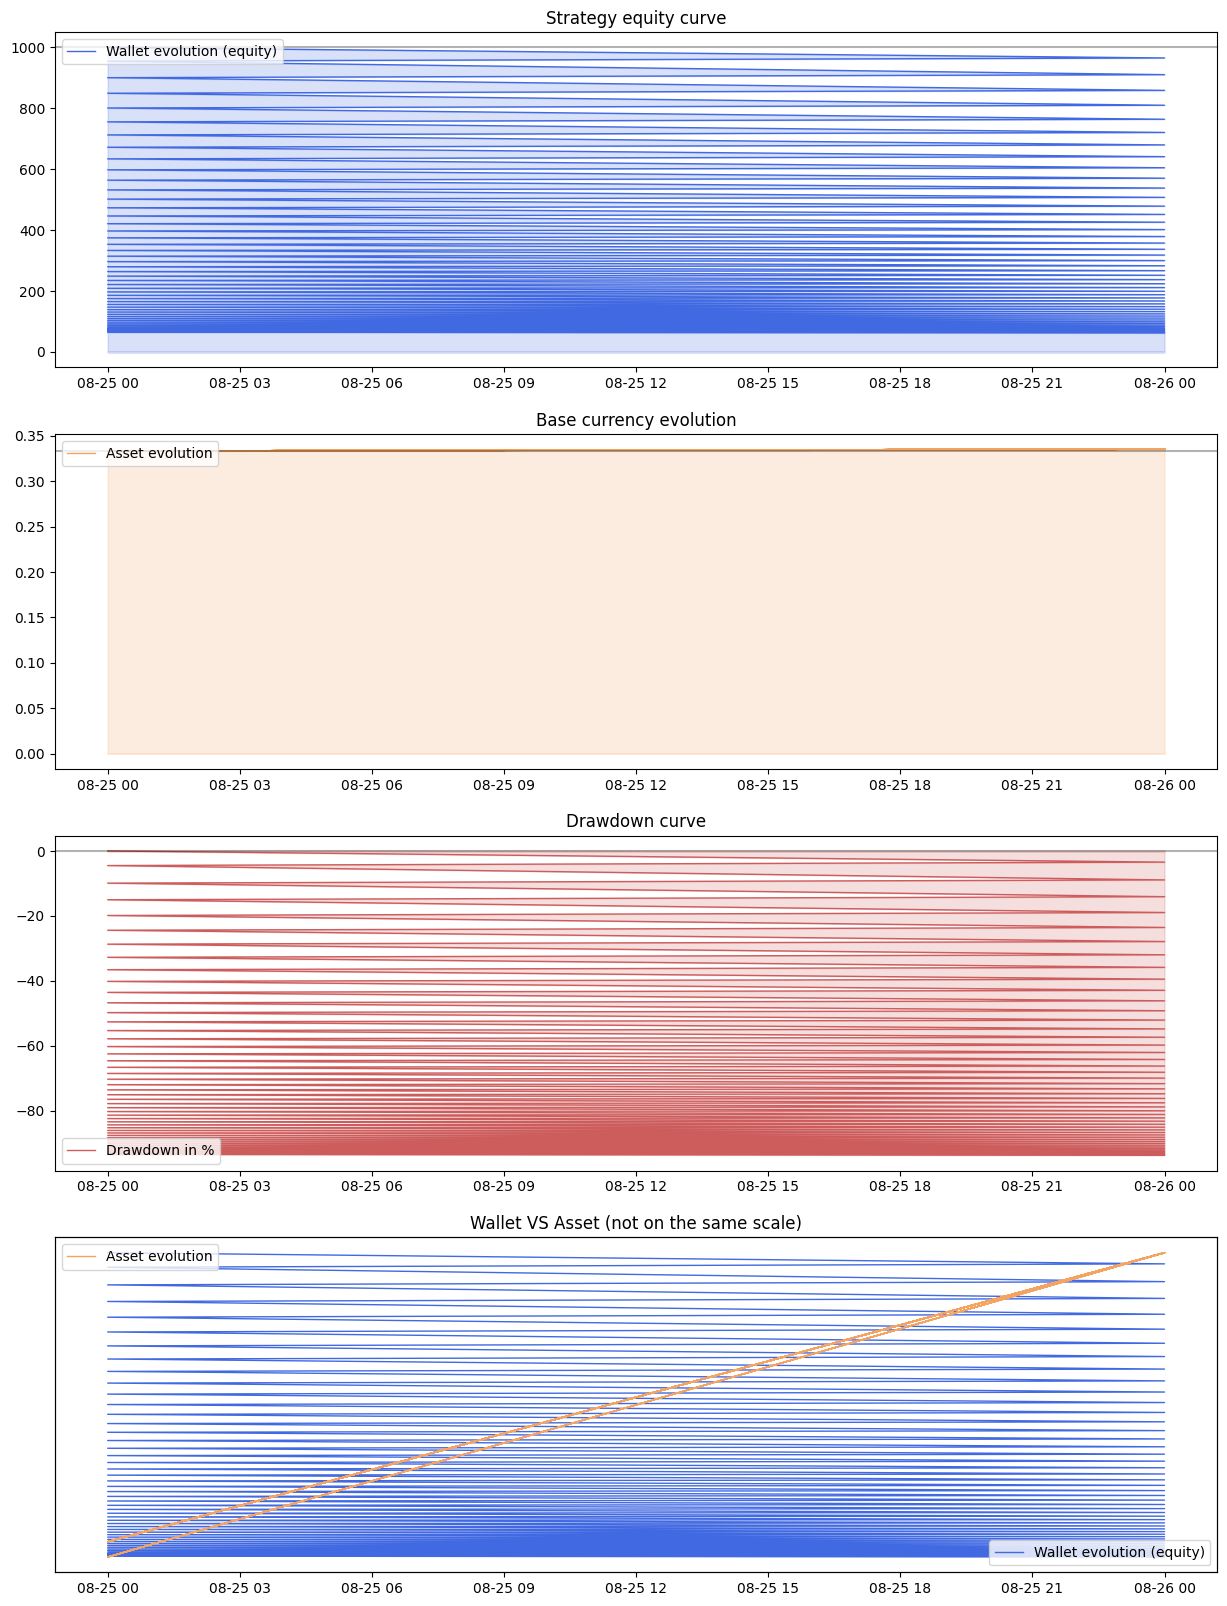

In [13]:
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)